In [3]:
import plotly.express as px
import numpy as np
from tqdm import tqdm
import pandas as pd

from scipy.spatial import distance_matrix
from sklearn.manifold import MDS

from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import os
from MPSE.MPSE import mview
from utils import *

# import pyvista as pv

%matplotlib inline

2022-11-18 09:02:11.179353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 09:02:11.944390: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 09:02:13.032068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/insane/.cache/pypoetry/virtualenvs/3d-reconstruction-GT1uMocM-py3.10/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-18 09:02:13.032129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64]

In [23]:
pix3D_dataset = [
    'Pix3D:chair:0132',
    'Pix3D:chair:1582',
    'Pix3D:sofa:0912',
    'Pix3D:table:0777',
    'Pix3D:table:1665',
    'Pix3D:sofa:0909',
]

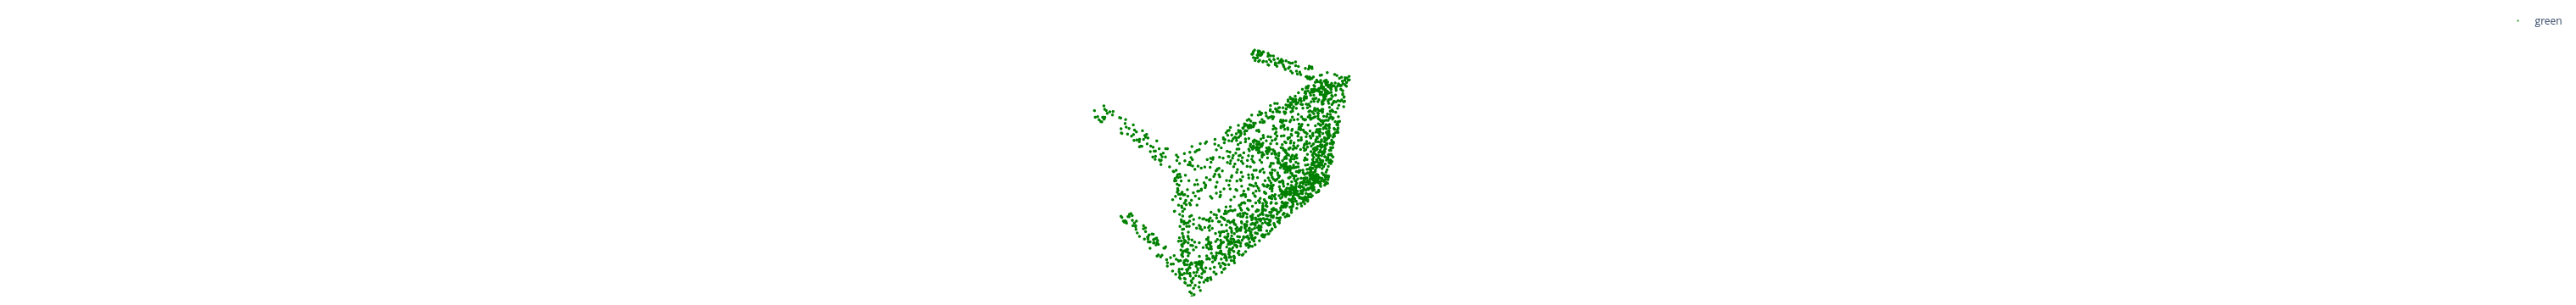

In [24]:
pix3d_datadir = '/run/media/insane/My 4TB 2/Big Data/MPSE/Data/pix3d/'
shapened_datadir = '/run/media/insane/My 4TB 2/Big Data/MPSE/Data/ShapeNetCore/ShapeNetCore.v2'
modelnet_datadir = None

# dataset = "ShapeNet:airplane:4b4fd540cab0cdf3f38bce64a8733419"
# dataset = "ModelNet10:chair:0001"
# dataset = "Pix3D:chair:0132"

points = get_dataset_points(pix3D_dataset[3], datadir=pix3d_datadir, n_points=2048)

plot_3D_paper([apply_transformation(points, getRotationMatrix(0, 'y'))]).show()

In [25]:
# points = get_dataset_points('toy_points', 1024)
# points = get_dataset_points('ModelNet10:chair:0001', 1024)
# points = get_dataset_points('ModelNet10:desk:0005', 512)
# points = get_dataset_points('ModelNet10:desk:0006', 512)
# points = get_dataset_points('ModelNet10:desk:0013', 512)
# points = get_dataset_points('ModelNet10:bed:0001', 512)
# points = get_dataset_points('ModelNet10:bed:0003', 512)

# points = get_dataset_points('ModelNet10:bathtub:0005', 512)
# points = get_dataset_points('ModelNet10:sofa:0010', 512)

# x = 1
# for i in range(x, x+10):
#     points = get_dataset_points(f'ModelNet10:toilet:{i:04}', 512)
#     plot_3D([points]).show()

In [26]:
# cloud = pv.PolyData(points)
# cloud.plot(jupyter_backend='pythreejs')
# cloud.plot(jupyter_backend='ipygany')

In [27]:
# volume = cloud.delaunay_3d(alpha=0.1)
# shell = volume.extract_geometry()
# shell.plot(jupyter_backend='ipygany')

In [28]:
labeled_perspectives = []
perspectives, projection_mats = get_randomized_all_persps(points, 5)
for perspective in perspectives:
    labeled_perspectives.append(give_ids(perspective))

proj = 'n_persp'
if proj == 'n_persp':
    labeled_perspectives = visible_in_n_persp(labeled_perspectives, 4)
elif proj == 'ray':
    labeled_perspectives = [
        ray_traceZ(p, n_raysX=600, n_raysY=600) for p in tqdm(labeled_perspectives)
    ]

In [97]:
plot_3D([add_col(remove_ids(labeled_perspectives[0]))]).show()

In [29]:
dist_mats, weights_mats = get_dist_weights(labeled_perspectives, len(points), ndim=2)

points_per_persp = np.array(show_points_least_persp(weights_mats))
points_per_persp = points_per_persp/points_per_persp.max() * 100

fig = px.bar(points_per_persp, x=range(1, len(points_per_persp)+1), y=points_per_persp, title="Points per Perspective")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

5it [00:28,  5.72s/it]


In [30]:
baseline = get_baseline_metrics(points, dist_mats)
print('Chamfer:', baseline['chamfer'])
print('EMD:', baseline['EMD'])
# plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

# plot_3D([embeddings]).show()

4 Point Alignment: 100%|████████████████| 10000/10000 [00:02<00:00, 4523.86it/s]


Chamfer: 4.361488018515329
EMD: 4.240532542280305


mview.MPSE():
  data details:
    number of perspectives : 8
    number of samples : 2048
  visualization details:
    embedding dimension : 3
    image dimension : 2
    visualization type : mds
  setup visualization instance for perspective 1 :
    mview.MDS():
      data details:
        number of samples : 2048
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 7.61e-01
  setup visualization instance for perspective 2 :
    mview.MDS():
      data details:
        number of samples : 2048
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 7.53e-01
  setup visualization instance for perspective 3 :
    mview.MDS():
      data details:
        number of samples : 2048
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 7.54e-01
  setup visuali

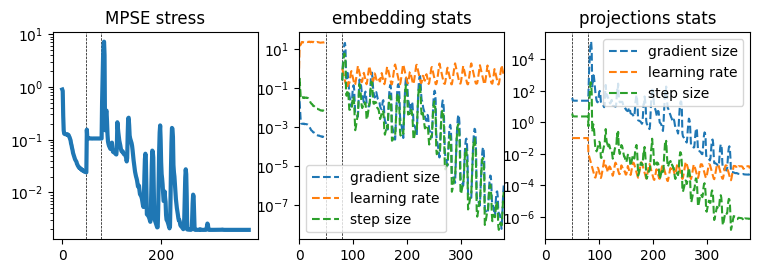

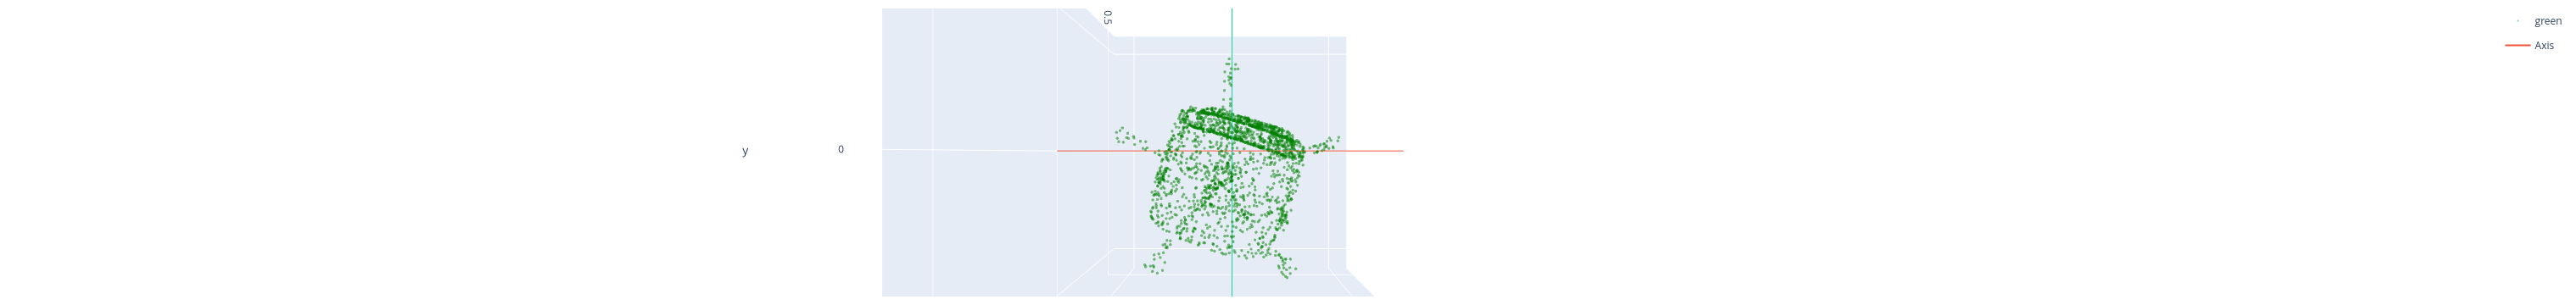

In [13]:
mv = mview.basic(dist_mats.copy(), #
                 batch_size = 2048,
                 max_iter=300, min_grad=1e-4, min_cost=1e-4,
                 verbose=2, 
                 smart_initialization=True,
                 weights=weights_mats.copy(),
                 
                 # For fixed projections
                 # fixed_projections = projection_mats,
                 
                 # For variable projections
                 fixed_projections = None,
                 initial_projections = 'cylinder'
                )

emb_plot = mv.plot_embedding()
imgs_plot = mv.plot_images()
comp_plot = mv.plot_computations()

plt.show()

embeddings = mv.X.copy()
plot_3D([embeddings]).show()

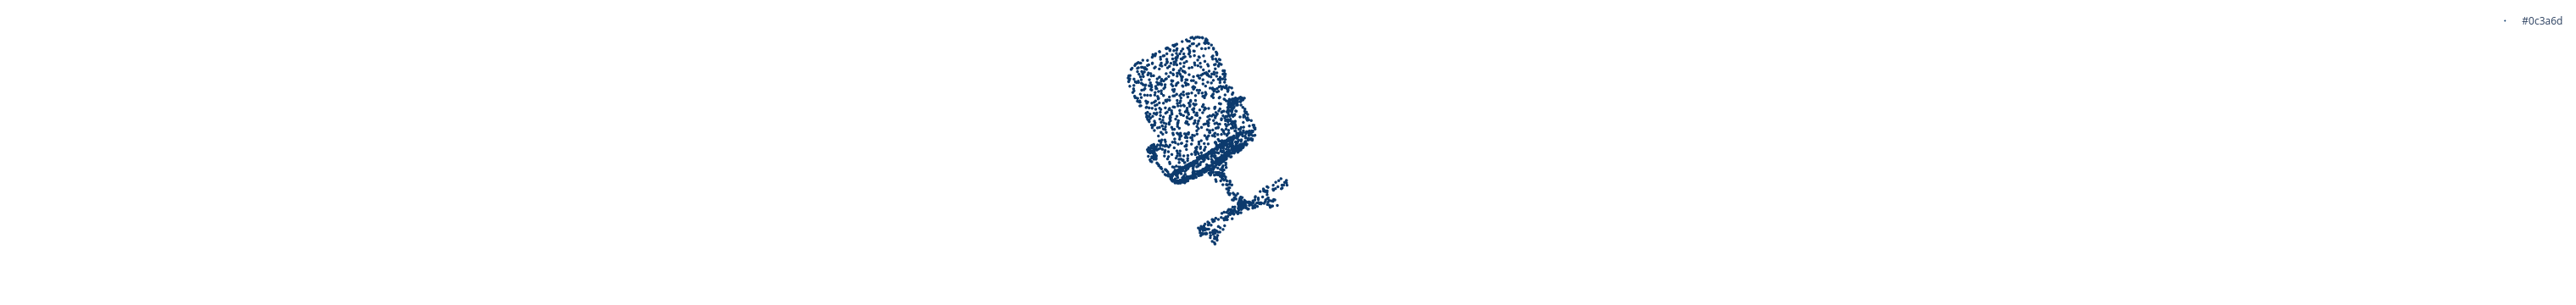

In [14]:
plot_3D_paper([apply_transformation(embeddings, getRotationMatrix(40, 'x'))], point_size=2, colors=['#0c3a6d']).show()

In [ ]:
val = np.unique(np.triu(distance_matrix(embeddings, embeddings)))
val.sort()

px.histogram(val, title="Distance distribution between points")

In [ ]:
rand_embeddings = np.random.rand(*points.shape)
rand_embeddings = (rand_embeddings - rand_embeddings.min()) * (points.max() - points.min()) + points.min()

rand_embeddings.min(), rand_embeddings.max(), rand_embeddings.mean()

In [ ]:
points.min(), points.max(), points.mean()

In [ ]:
chamfer_distance_numpy(np.expand_dims(rand_embeddings, axis=0), np.expand_dims(points, axis=0))

In [ ]:
emd(rand_embeddings, points)

2022-11-18 09:10:56.962350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 09:10:57.080463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 09:10:57.080940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 09:10:57.086832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Chamfer Distance: 3.4475173794757548
Loss: 0.03144894943392435
EMD: 3.141342825690438
CPU times: user 3.63 s, sys: 370 ms, total: 4 s
Wall time: 5.74 s


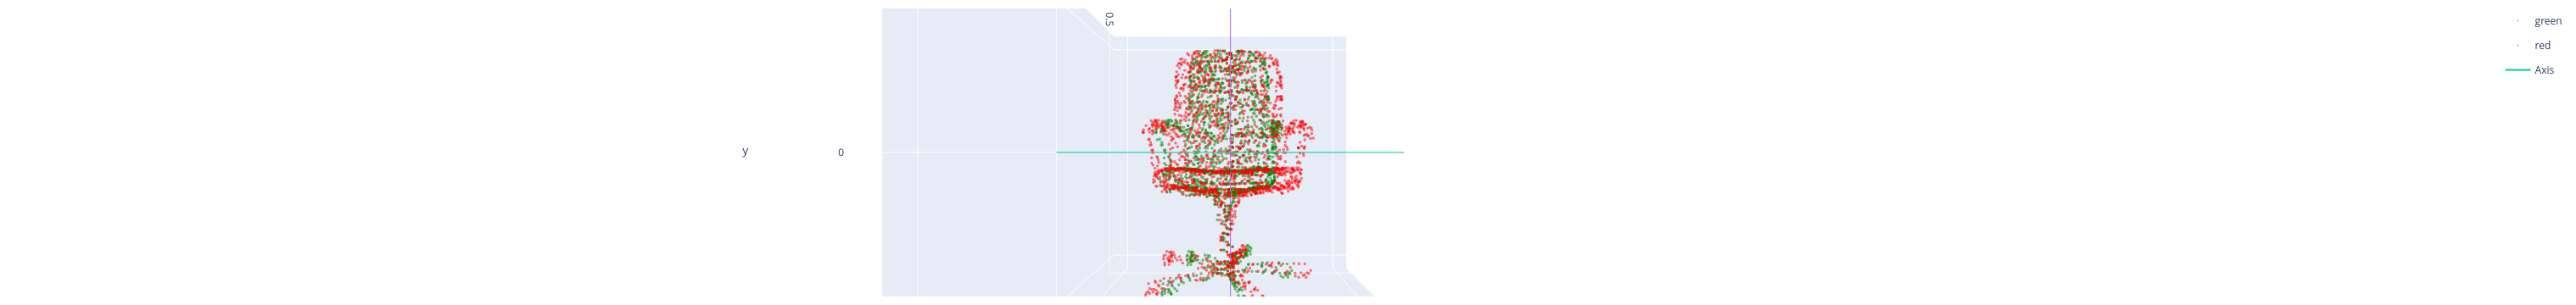

In [15]:
%%time

trans_mat, loss = get_optimal_trans_mat(embeddings, points, iterations=1600)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('Loss:', loss)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

4 Point Alignment: 100%|████████████████| 10000/10000 [00:02<00:00, 4591.09it/s]


1.085774393258393e-05
Chamfer Distance: 0.002171548786516786
EMD: 0.001085774393258393


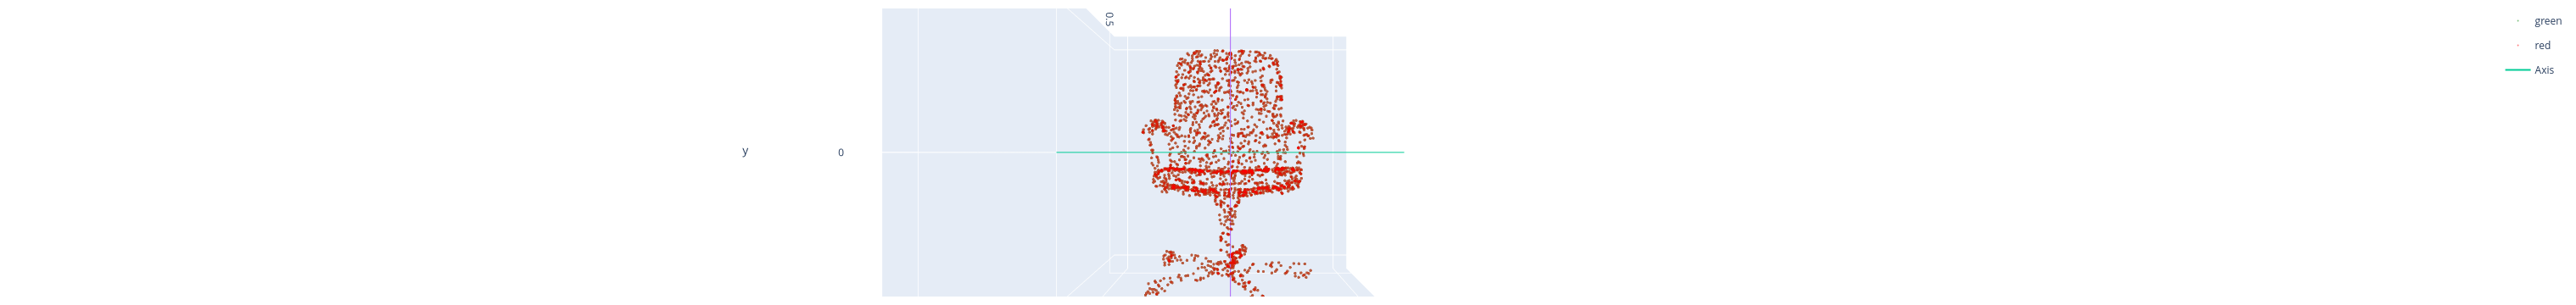

In [16]:
trans_mat, loss = get_4pointsample_transform_mat(embeddings, points)
print(loss)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

In [17]:
trans_mat, loss = get_svd_trans(embeddings, points)
print('Loss', loss)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

Loss 0.12227823280011592
Chamfer Distance: 12.69300483952858
EMD: 11.759990049958018


In [ ]:
range_x = [
    points[:, 0].min(),
    points[:, 0].max()
]
range_y = [
    points[:, 1].min(),
    points[:, 1].max()
]
range_z = [
    points[:, 2].min(),
    points[:, 2].max()
]

d_th = max([r[1] - r[0] for r in [range_x, range_y, range_z]])

result = get_icp_trans_mat_by_random_rotation(embeddings, points, d_th=d_th, max_iter=1000)
X, Y = result['trans_mat_points_a'], result['trans_mat_points_b']
champ_dist = chamfer_distance_numpy(np.expand_dims(X, axis=0), np.expand_dims(Y, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(X,Y))